In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

from scipy.integrate import cumulative_trapezoid

import warnings
warnings.filterwarnings("ignore")

In [4]:
streaming=pd.read_csv('cpu4.csv')
for i in range(len(streaming)):
    streaming['timestamp'].iloc[i]=datetime.fromtimestamp(streaming['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in streaming.columns if i not in ['timestamp']]
for col in cols:
    streaming[col]=pd.to_numeric(streaming[col])
streaming['timestamp'] = pd.to_datetime(streaming['timestamp'])
streaming.tail()

,timestamp,value,label
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0
17567,2016-09-23 19:55:00,-0.036137,0


Text(0.5, 1.0, 'Streaming Dataset')

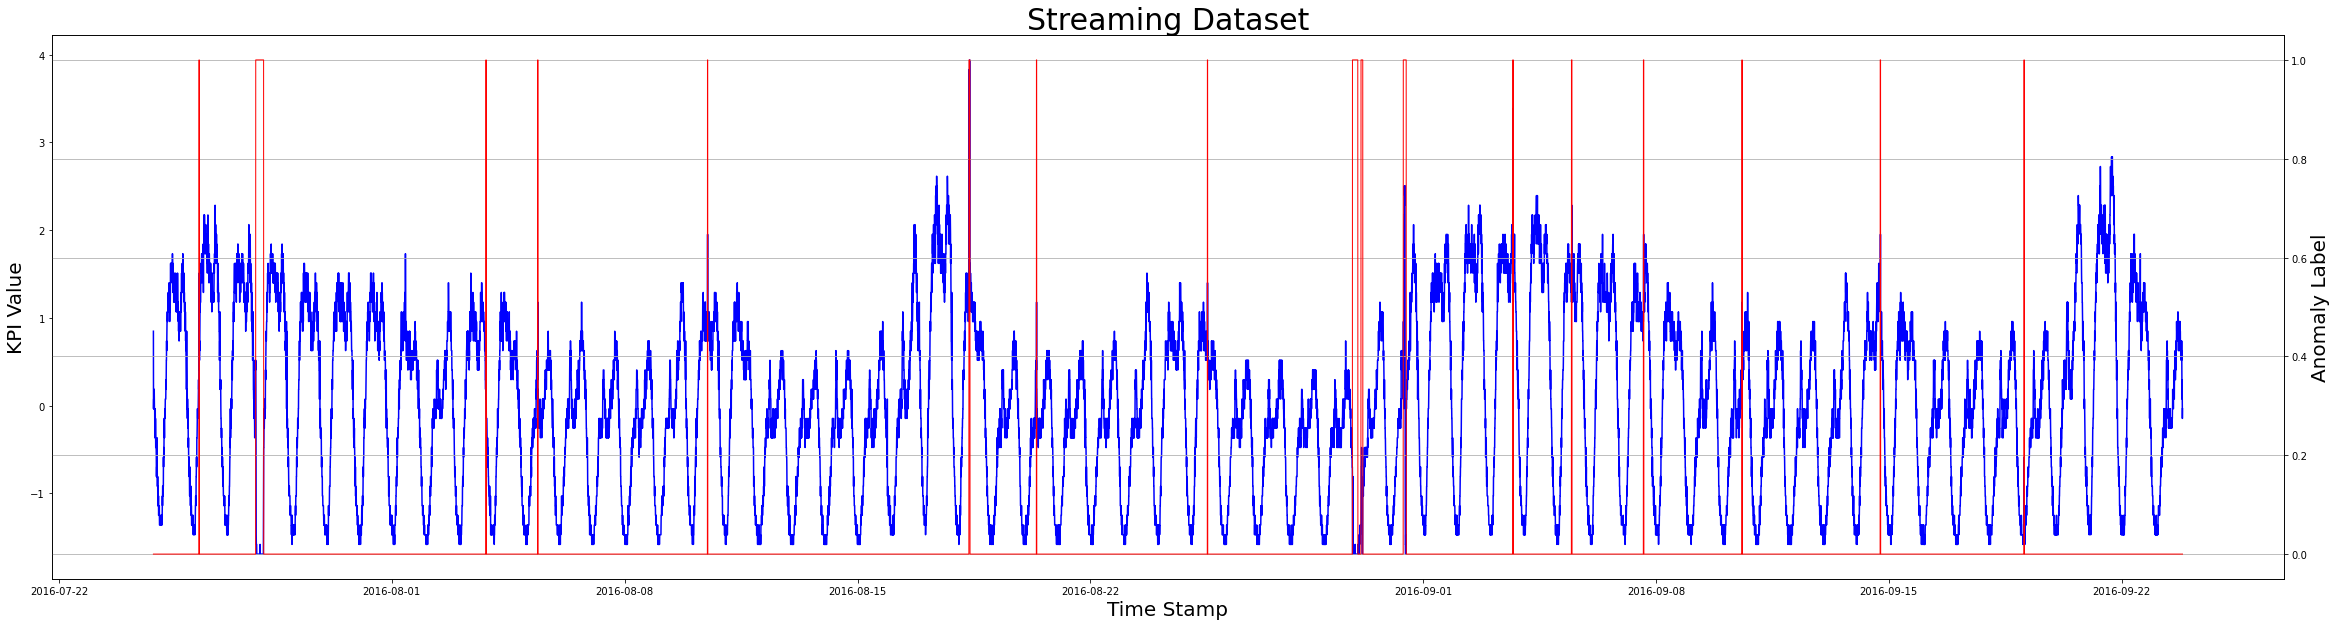

In [6]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(streaming['timestamp'], streaming['value'], color='blue')
ax2a.plot(streaming['timestamp'], streaming['label'], color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

In [8]:
value=streaming['value']
timestamp=streaming['timestamp']

In [9]:
first_diff = value.diff()[1:]

In [10]:
first_diff

1       -0.883438
2        0.110430
3        0.000000
4       -0.110430
5        0.220859
           ...   
17563   -0.220859
17564    0.220859
17565   -0.220859
17566   -0.220859
17567    0.110430
Name: value, Length: 17567, dtype: float64

In [11]:
new_time=timestamp[1:]

Text(0.5, 1.0, 'Streaming Dataset')

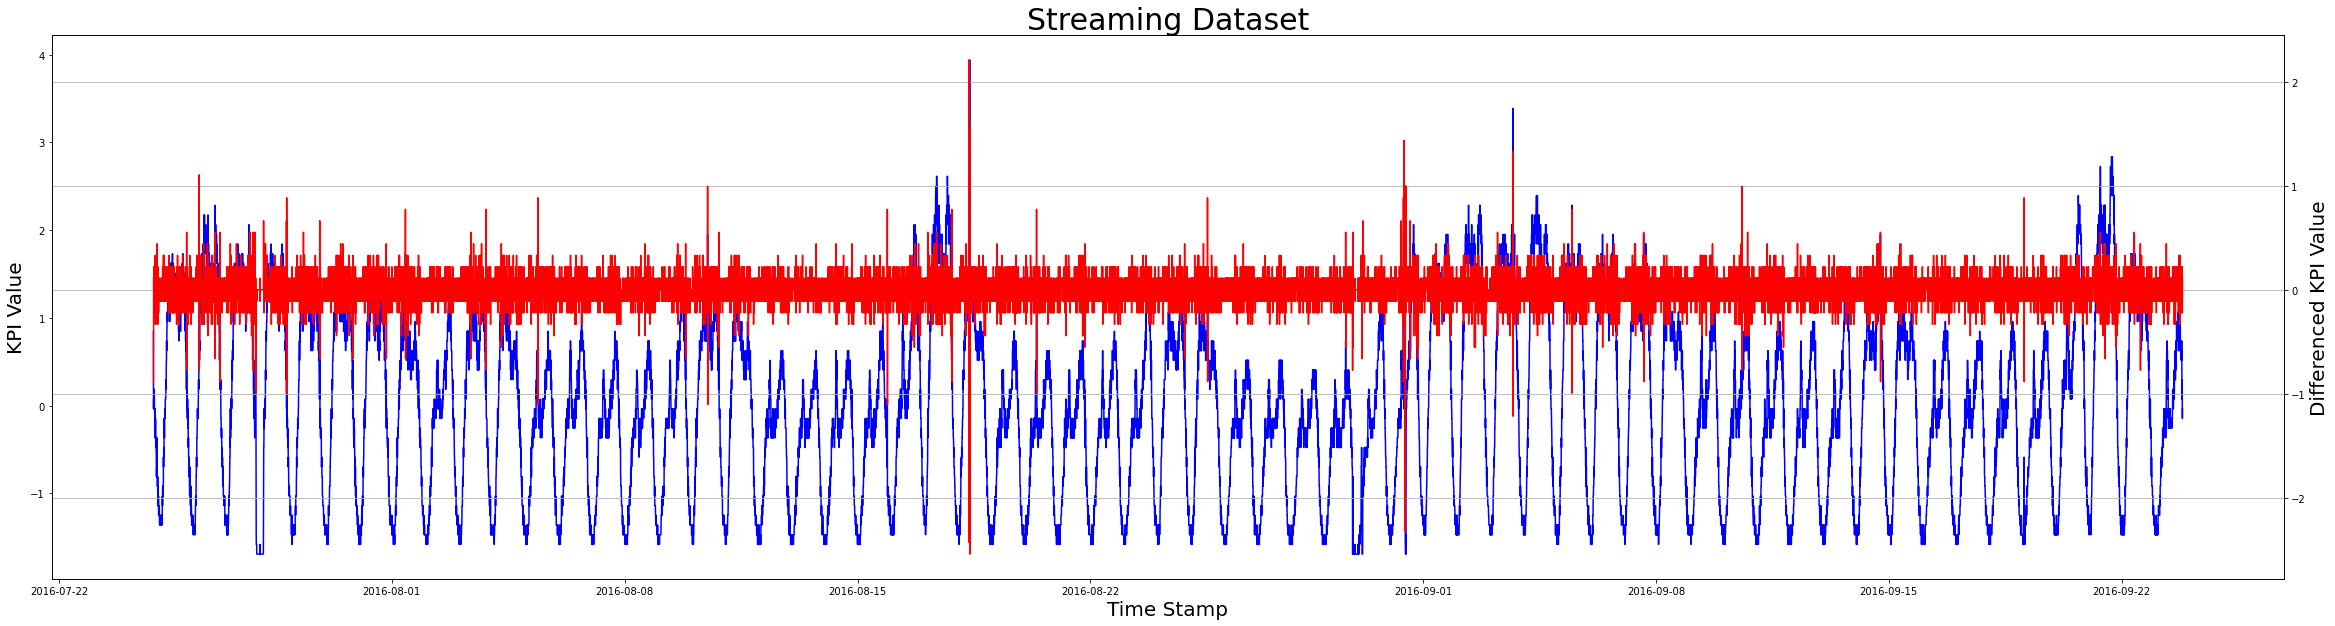

In [12]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, value, color='blue')
ax2a.plot(new_time, first_diff, color='red')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Differenced KPI Value', fontsize=20)

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

In [13]:
used_dataset = value
used_dataset

0        0.847300
1       -0.036137
2        0.074292
3        0.074292
4       -0.036137
           ...   
17563    0.074292
17564    0.295152
17565    0.074292
17566   -0.146567
17567   -0.036137
Name: value, Length: 17568, dtype: float64

<BarContainer object of 20 artists>

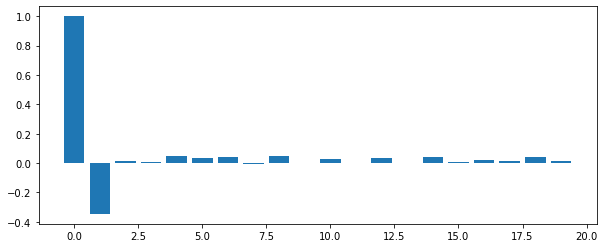

In [14]:
plt.figure(figsize=(10,4))
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

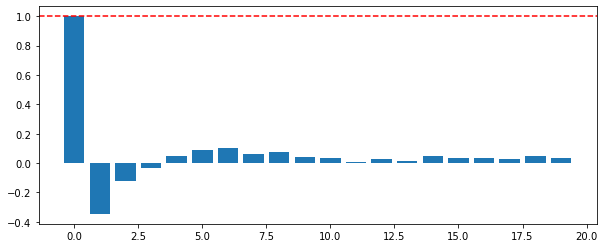

In [15]:
plt.figure(figsize=(10,4))
pacf_vals = pacf(first_diff)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.axhline(y=1, color='red', linestyle='--')

FROM THE ACF GRAPH:
###################
p is 12 since it has no significant positive spikes
d is 1 from the first difference
q is 1 significant negative spikes
  
FROM THE PACF GRAPH:
####################
P is 0 since it has a significant positive spike
D is 1 from the first seasonal difference
Q is 1 significant negative seasonal spikes
m is 10 from the seasonal analysis


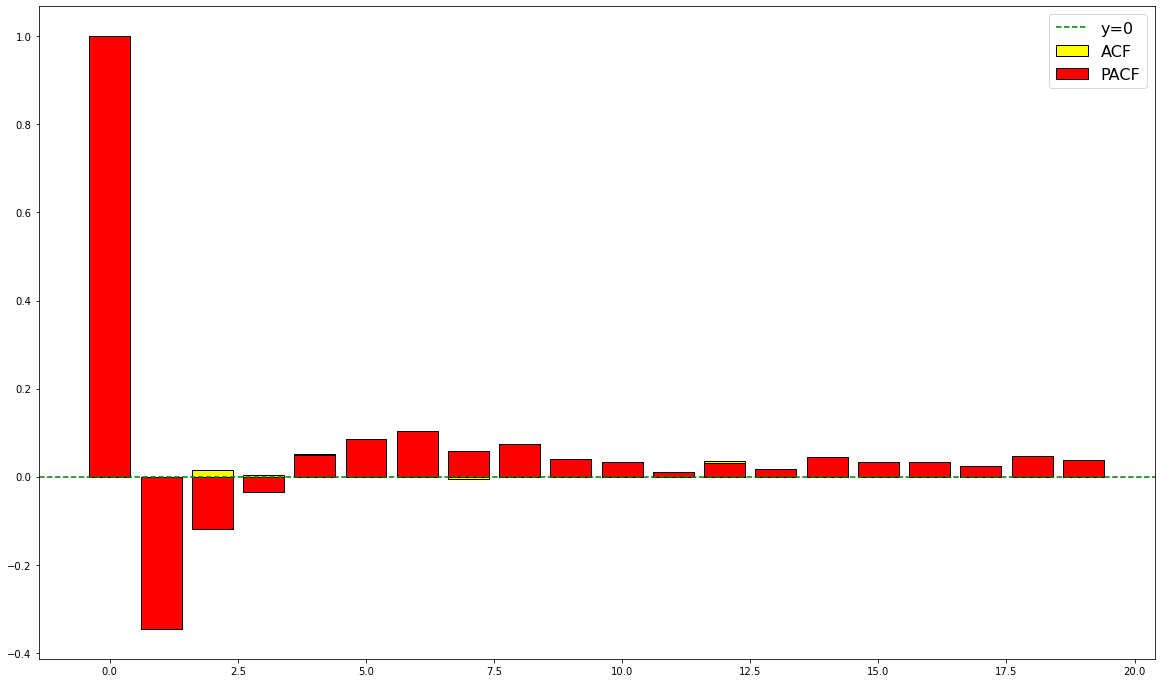

In [16]:
plt.figure(figsize=(20,12))
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags], color='yellow', edgecolor='black')
plt.bar(range(num_lags), pacf_vals[:num_lags], color='red' , edgecolor='black')
plt.axhline(y=0, color='green', linestyle='--')

plt.legend(('y=0', 'ACF', 'PACF'), fontsize=16)

print("FROM THE ACF GRAPH:")
print("###################")
print("p is 12 since it has no significant positive spikes")
print("d is 1 from the first difference")
print("q is 1 significant negative spikes")
print("  ")
print("FROM THE PACF GRAPH:")
print("####################")
print("P is 0 since it has a significant positive spike")
print("D is 1 from the first seasonal difference")
print("Q is 1 significant negative seasonal spikes")
print("m is 10 from the seasonal analysis")

In [17]:
# plt.figure(figsize=(20,10))
# plot_pacf(used_dataset)
# plt.show()

In [18]:
percent_test=80
percent_test=percent_test/100

time=timestamp 
time_point=timestamp[round(len(used_dataset)*percent_test)]
time_point

train, test = used_dataset.loc[timestamp <= time_point], used_dataset.loc[timestamp > time_point]

print(f"Number of Training Data: {train.shape[0]}")
print(f"Number of Testing Data: {test.shape[0]}")

Number of Training Data: 14055
Number of Testing Data: 3513


In [19]:
order = (1,1,1)
seasonal_order = (1, 0, 1, 10)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.43736D-01    |proj g|=  3.58588D-02


 This problem is unconstrained.



At iterate    5    f= -5.44442D-01    |proj g|=  3.75761D-02

At iterate   10    f= -5.44582D-01    |proj g|=  1.68750D-02

At iterate   15    f= -5.44586D-01    |proj g|=  8.85565D-03

At iterate   20    f= -5.44733D-01    |proj g|=  8.88789D-02

At iterate   25    f= -5.45421D-01    |proj g|=  1.04832D-01

At iterate   30    f= -5.45811D-01    |proj g|=  4.10109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   5.137D-06  -5.458D-01
  F = -0.54581095899241261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Result

In [20]:
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

Text(0, 0.5, 'Error')

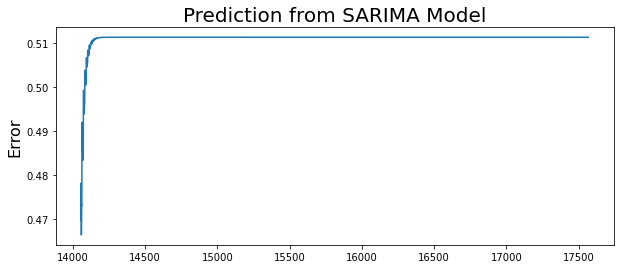

In [21]:
plt.figure(figsize=(10,4))
plt.plot(predictions)
#plt.axhline(0, linestyle='--', color='k')
plt.title('Prediction from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Error')

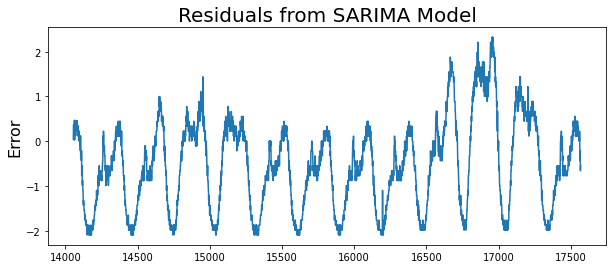

In [22]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
#plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

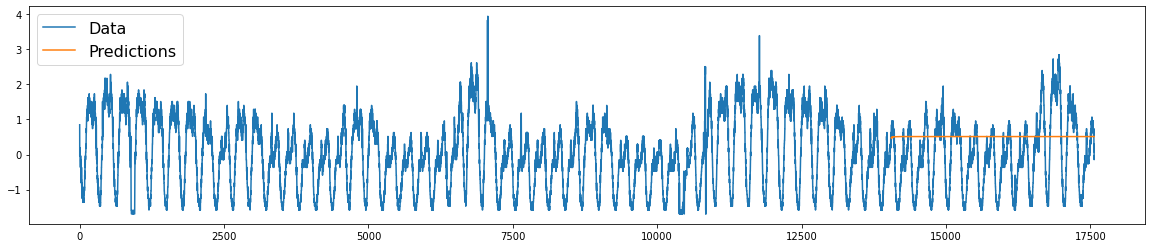

In [24]:
plt.figure(figsize=(20,4))

plt.plot(value)
plt.plot(predictions)
#plt.plot(residuals)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [47]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test)),4))

Mean Absolute Percent Error: 0.0045


In [48]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.0054089877455788995


# Using the Rolling Forecast Origin

In [51]:
rolling_predictions = test.copy()

In [52]:
train_end=len(train)
train_end

16128

In [54]:
# for train_end in test.index:
#     train = used_dataset[:train_end-0]
#     model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
#     model_fit = model.fit()
    
#     pred = model_fit.forecast()
#     rolling_predictions[train_end] = pred

In [111]:
rolling_residuals = test - rolling_predictions

Text(0, 0.5, 'Error')

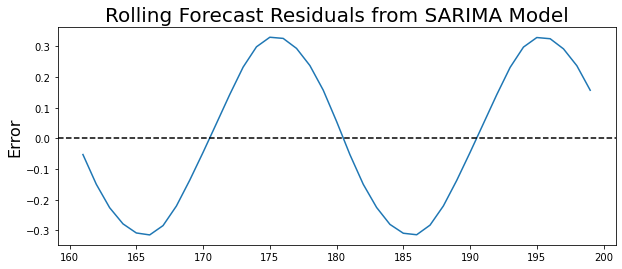

In [112]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

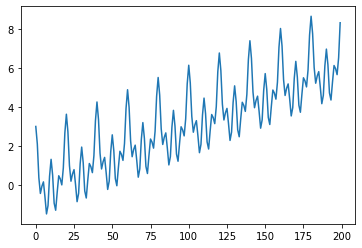

In [113]:
plt.plot(used_dataset)

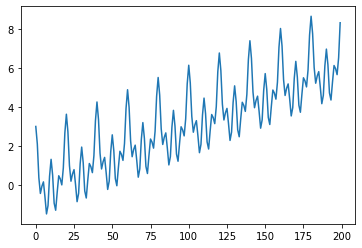

In [114]:
plt.plot(data)

Text(0, 0.5, 'y')

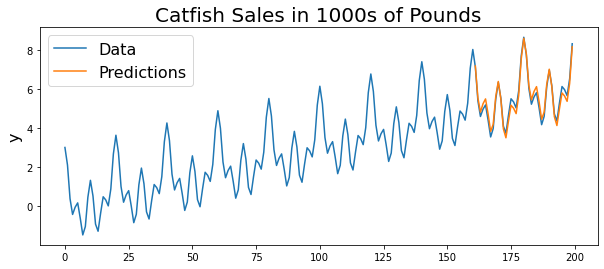

In [115]:
plt.figure(figsize=(10,4))

plt.plot(data)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('y', fontsize=16)

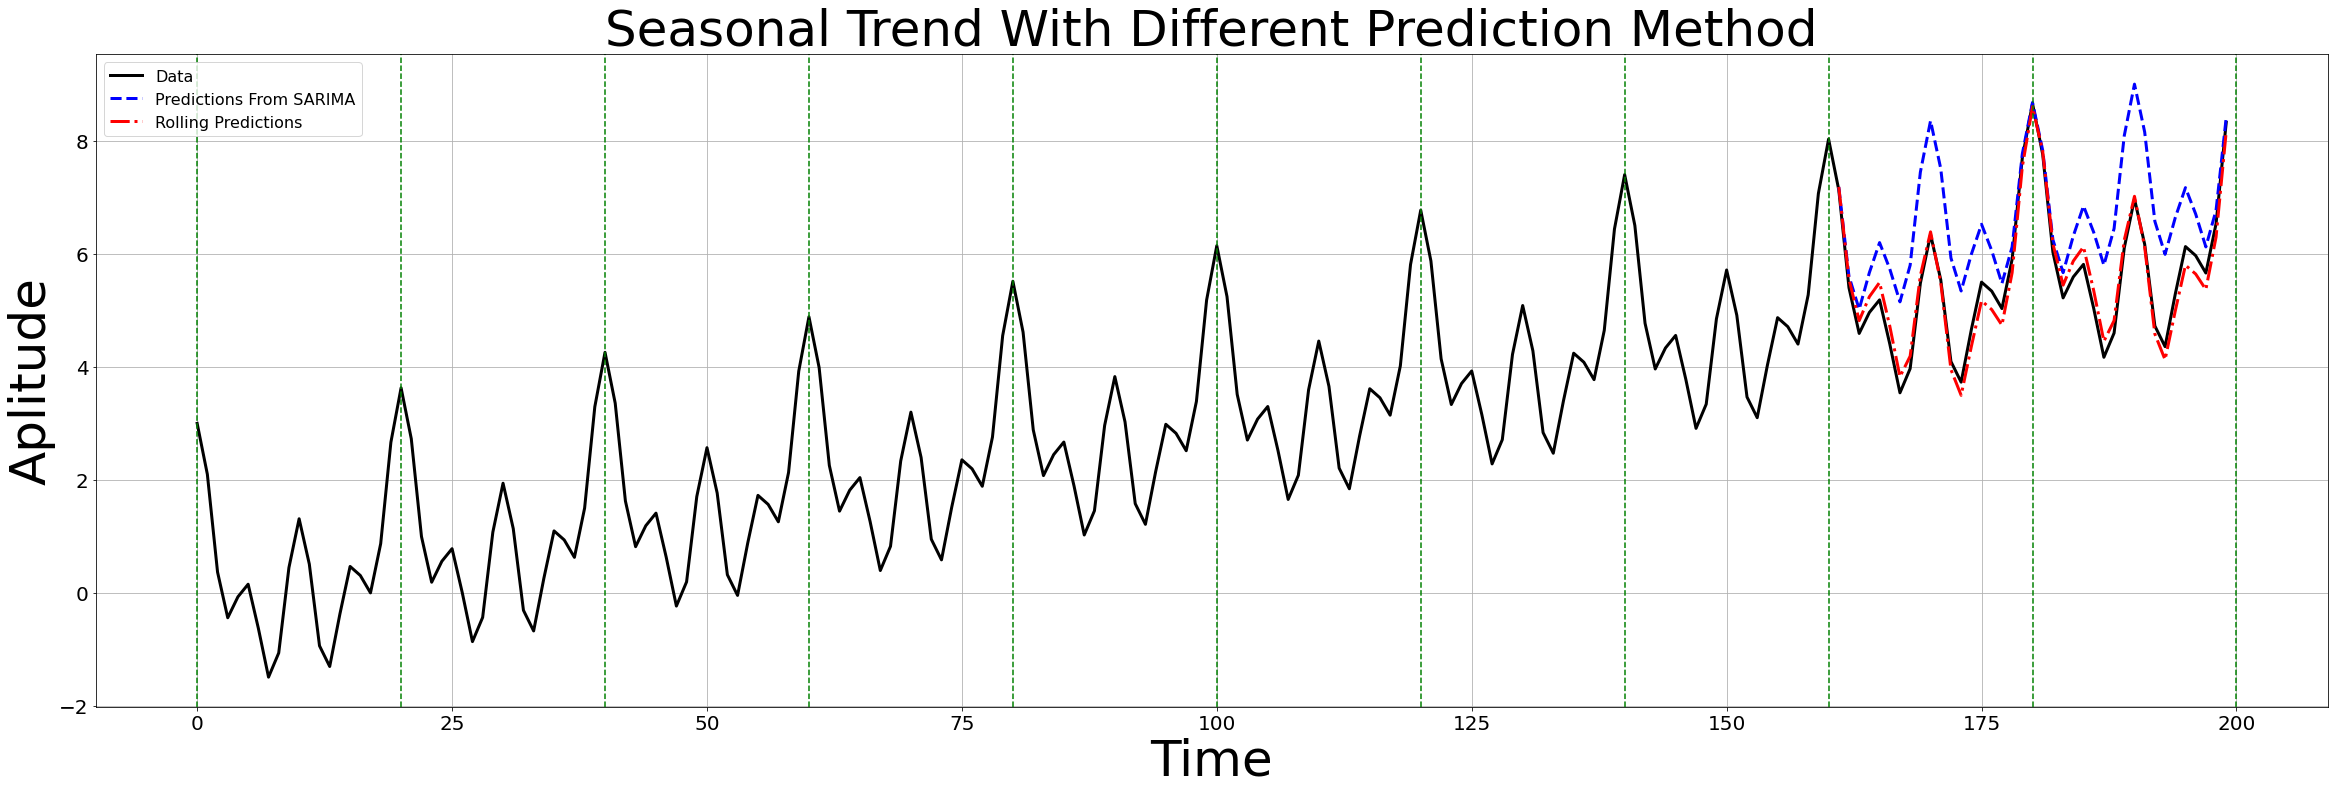

In [138]:
plt.figure(figsize=(40,12))

plt.plot(data, color='black', linewidth=3.0)
plt.plot(predictions, color='blue', linewidth=3.0, linestyle='--')
plt.plot(rolling_predictions, color='red', linewidth=3.0, linestyle='dashdot')

plt.axvline(x=20*0, color='green', linestyle='--')
plt.axvline(x=20*1, color='green', linestyle='--')
plt.axvline(x=20*2, color='green', linestyle='--')
plt.axvline(x=20*3, color='green', linestyle='--')
plt.axvline(x=20*4, color='green', linestyle='--')
plt.axvline(x=20*5, color='green', linestyle='--')
plt.axvline(x=20*6, color='green', linestyle='--')
plt.axvline(x=20*7, color='green', linestyle='--')
plt.axvline(x=20*8, color='green', linestyle='--')
plt.axvline(x=20*9, color='green', linestyle='--')
plt.axvline(x=20*10, color='green', linestyle='--')

plt.title('Seasonal Trend With Different Prediction Method', fontsize=50)
plt.xlabel('Time', fontsize=50)
plt.ylabel('Aplitude', fontsize=50)
plt.grid(True, which='both')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(('Data', 'Predictions From SARIMA', 'Rolling Predictions'), fontsize=16)

plt.savefig('Seasonal Trend With Different Prediction Method')